# INTRODUÇÃO

Este notebook tem o objetivo de realizar a análise de sentimentos nos dados coletados do Twitter.  
Para isso, será necessário treinar o modelo com uma base de dados de tweets já classificados como Positivos, Neutros ou Negativos.  
Tanto a base de dados de treino como a de teste passarão por tratamentos de normalização dos textos, técnicas de tfidf, ngrams, entre outras.  
No final, os tweets coletados serão classificados como Positivos, Neutros ou Negativos.

# PREPARAÇÃO

#### IMPORTAÇÃO DAS BIBLIOTECAS

In [64]:
import pandas as pd

# TRATAMENTO DE TEXTOS
import nltk
from string import punctuation
from nltk import tokenize
import unidecode

# MODELO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

#VISUALIZAÇÃO
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#### SUBINDO AS BASES DE TREINO E TESTE

In [20]:
df_treino = pd.read_csv('tweets_treino.csv',sep=';')

In [5]:
df_treino.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,1,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,1,:)


In [12]:
df_teste = pd.read_csv('resultados_coleta.csv')

In [19]:
df_teste.head()

,tweets,time
0,Boa tarde pra vcs! Em homenagem ao dia do vete...,2021-09-09 15:45:45
1,"100% mãe de pet, acalmando o filho que tá com ...",2021-09-09 15:47:34
2,Achei foto dos pet da minha tia quando era nen...,2021-09-09 15:51:40
3,Malu tá no pet desde as 8 da manhã e eu tô sen...,2021-09-09 15:54:06
4,Vai ter mutirão de vacinação animal na UBS pet...,2021-09-09 15:54:11


# TRATAMENTO

#### DROPANDO NULOS E CRIANDO COLUNA DE CLASSIFICAÇÃO

In [21]:
df_treino = df_treino.dropna(subset=['tweet_text', 'sentiment'])

In [22]:
df_treino = df_treino[['tweet_text', 'tweet_date', 'sentiment']]

In [23]:
df_treino['classificacao'] = df_treino['sentiment'].apply(lambda x : 'Positivo' if x == 1 else 'Neutro' if x == 2 else 'Negativo')

#### BALANCEAMENTO

É de grande importância que os dados de treino estejam balanceados, para que o modelo não seja enviesado e gere over fitting.  
  
Para entender melhor sobre Over Fitting: http://www.feat.engineering/important-concepts.html

In [24]:
df_treino['classificacao'].value_counts()

Positivo    33334
Negativo    33333
Neutro      33333
Name: classificacao, dtype: int64

<AxesSubplot:>

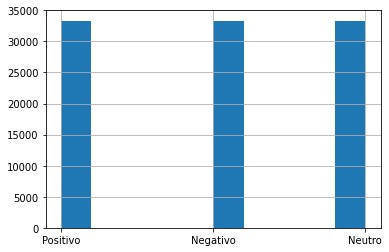

In [25]:
df_treino['classificacao'].hist()

#### FUNÇÃO DE TRATAMENTO DOS TEXTOS

In [38]:
def tratar(df, coluna):

  palavras_irrelevantes = nltk.corpus.stopwords.words("portuguese")
  pontuacao = []
  for ponto in punctuation:
    pontuacao.append(ponto)
  pontuacao_stopwords = pontuacao + palavras_irrelevantes
  token_pontuacao = tokenize.WordPunctTokenizer()
  sem_acentos = [unidecode.unidecode(texto) for texto in df[coluna]]
  stopwords_sem_acentos = [unidecode.unidecode(texto) for texto in pontuacao_stopwords]
  stemmer = nltk.RSLPStemmer()

  df['texto_tratado'] = sem_acentos

  frase_processada = []

  for texto in df['texto_tratado']:
    
    nova_frase = []
    texto = texto.lower()
    texto = texto.replace('rt ','')
    texto = texto.replace('http','')
    texto = texto.replace('...','')
    texto = texto.replace('://','')
    texto = texto.replace('..','')
    palavras_texto = token_pontuacao.tokenize(texto)
    for palavra in palavras_texto:
        if palavra not in pontuacao_stopwords:
            nova_frase.append(stemmer.stem(palavra))
    frase_processada.append(' '.join(nova_frase))

  df['texto_tratado'] = frase_processada

In [39]:
tratar(df_treino,'tweet_text')

In [42]:
df_treino.sample(5)

,tweet_text,tweet_date,sentiment,classificacao,texto_tratado
47228,🐝 viviheon. thats it. thats the tweet. meu nen...,Tue Oct 02 03:56:22 +0000 2018,0,Negativo,viviheon that it that the tweet nen demal q od...
88352,Adoro está selva de pedra. #SAMPA #reunioes #p...,Thu Oct 18 14:52:56 +0000 2018,2,Neutro,ador selv pedr samp reunio pesquis dissertacao...
88002,Autismo é tema de campanha e será discutido em...,Fri Oct 19 18:21:24 +0000 2018,2,Neutro,aut tem campanh ser discut audienc publ saib s...
8184,Meu canal de bad fav apoia o bololo :)) https:...,Mon Oct 08 02:21:44 +0000 2018,1,Positivo,canal bad fav apo bolol :)) st co qg4qqpmeay
45359,fico irriradissima quando me chamam de mariana...,Tue Oct 02 08:31:02 +0000 2018,0,Negativo,fic irriradiss cham mari gt ;:(


# TESTE

In [49]:
tratar(df_teste,'tweets')

In [50]:
df_teste.head()

,tweets,time,texto_tratado
0,Boa tarde pra vcs! Em homenagem ao dia do vete...,2021-09-09 15:45:45,boa tard pra vc homen dia veterinari quer deix...
1,"100% mãe de pet, acalmando o filho que tá com ...",2021-09-09 15:47:34,100 mae pet acalm filh ta med barulh st co zn8...
2,Achei foto dos pet da minha tia quando era nen...,2021-09-09 15:51:40,ach fot pet tia nen heh gat aparec loj pai ai ...
3,Malu tá no pet desde as 8 da manhã e eu tô sen...,2021-09-09 15:54:06,malu ta pet desd 8 manh to sent tant falt ja
4,Vai ter mutirão de vacinação animal na UBS pet...,2021-09-09 15:54:11,vai ter mutira vacinaca animal ub pet amanh na...


#### FUNÇÃO DE CLASSIFICAÇÃO

In [48]:
regressao_logistica = LogisticRegression()

In [46]:
def classificar(df, texto, sentimento, df_teste, texto_teste):
  tfidf = TfidfVectorizer(lowercase=False,ngram_range=(1,2))

  treino_tfidf = tfidf.fit_transform(df[texto])
  teste_tfidf = tfidf.transform(df_teste[texto_teste]).todense()

  treino = treino_tfidf
  classe_treino = df[sentimento]
  teste = teste_tfidf

  regressao_logistica.fit(treino,classe_treino)

  classificacao = regressao_logistica.predict(teste)

  df_teste['sentimento'] = classificacao

In [51]:
classificar(df_treino, 'texto_tratado', 'classificacao', df_teste, 'texto_tratado')

C:\Users\Wesley Ribeiro\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [52]:
df_teste = df_teste[['time','tweets', 'texto_tratado', 'sentimento']]

In [58]:
df_teste.sample(5)

,time,tweets,texto_tratado,sentimento
8966,2021-09-30 22:14:03,eu sou nervosinha quando vou apresentar QUALQU...,nervos vou apresent qualqu cois ne dai ont int...,Positivo
1680,2021-09-14 13:10:29,Bom diaaa vou la no pet shop gastar 300 reais,bom diaa vou la pet shop gast 300 real,Positivo
5352,2021-09-23 16:32:13,tu tem pet e não chama de filho?? perai pô,pet nao cham filh ?? per po,Negativo
8053,2021-09-28 23:02:34,gastando o que tenho e o que não tenho p pagar...,gast nao p pag tod gast pet leon pi sensaca te...,Negativo
2128,2021-09-14 21:00:12,🤖 Seleção de Tutor Pet – Licenciatura em Quím...,seleca tut pet licenciat quim campu arapirac -...,Neutro


#### ANÁLISE DOS RESULTADOS

In [59]:
list(df_teste.query('sentimento == "Positivo"')['tweets'][:10])

['Boa tarde pra vcs! Em homenagem ao dia do veterinário, quero deixar o meu abraço a esses profissionais que cuidam dos nossos amores! Em especial ao veterinário do meu Thor aqui em Luís Eduardo Magalhães Animalia pet shop#tamojuntobmd https://t.co/Cq7Az5Lli6',
 'ela mt mamãe de pet yeri vc e a chungha seriam melhores amigas https://t.co/2b6kSpqKM7',
 'Ele desvaloriza a educação e é pet de partido político, fala de cotas em iniciação científica, o que move avanços no nosso país mas nem sabe como funciona o processo, não é uma competição, é por nota, oferta e demanda. ↓',
 'nossa eu tava vendo a hashtag pet regression e age regression no tiktok e notei uma coisa curiosa, pq 99% das pessoas ali eram branco?????',
 'Primeira vez que saio do pet  pra almoçar, tô até emocionada kkkkkkkkkk',
 'nao tem mamae mais feliz do que mamae de pet',
 '- qual o nome do pet\n- bowiv\n- oi?\n- bowiv\n- bowie?\n- bowiv\n- só um minuto\n- ...\n- qual é o nome do paciente que está aqui?\n- o nome do meu gat

In [60]:
list(df_teste.query('sentimento == "Neutro"')['tweets'][:10])

['cara nem me surpreendo, trabalhando no voluntariado eu vejo cada nome dos pet que olha https://t.co/xXFuDnZr2O',
 'as fãs do pet canadense nos quotes kkkkkkkk https://t.co/7eMPsGEl7x',
 'Petz Seu Pet Center de... oferece vaga para São Paulo-SPBanhista E Tosador Petz Pompéia https://t.co/va8AXbmErH',
 'Casadinhos e papais de pet https://t.co/Vdk7g8FViI',
 'Cheguei ao ponto do meu amor ser um pet. Seguimos https://t.co/2JHdn2VMJ2 https://t.co/r9S0hLeizU',
 'vai ter brasileira, favelada, ex vendendora de pastel, parda, bissexual, vegana, mãe de pet performando no vmas sim 🥂\n\nANITTA NO VMAs \n https://t.co/wiHQccYGn9',
 'aqui em palmares trabalhando ao sons de méééééé (a vizinha tem uma pet ovelha)',
 'BLOG DO LAURIBERTO: Fortaleza lança Selo Pet Friendly para comércio https://t.co/tiOYVjBgIj https://t.co/ZZMcsfZVvc',
 'A ordem de preferência:\n\nGilmar Laxante Mendes\nToffoli\nLewandowski\nKassio com K\nCarmem Lúcia (por ser pet do Laxante) https://t.co/n491GFUM2y',
 'A filha levou a 

In [61]:
list(df_teste.query('sentimento == "Negativo"')['tweets'][:10])

['100% mãe de pet, acalmando o filho que tá com medo dos barulhos. https://t.co/zn8u5eMAME',
 'Achei foto dos pet da minha tia quando era nenens hehe\n\nO gatinho apareceu na loja do meu pai, ai ela adotou hehehehe e o doguinho eu n sei daonde veio https://t.co/X7HRpzwiZh',
 'Malu tá no pet desde as 8 da manhã e eu tô sentindo tanta falta dela já',
 'Vai ter mutirão de vacinação animal na UBS pet amanhã, mas não vou conseguir ir, eu acho 🤔',
 'aí a moça da pet me mandou áudio emocionada dizendo que conseguiu fazer o penteado com o Evi queria nas meninas... estou chorando já faz uns 10min... dia de tosa é um dos dias que mais me deixa triste... ele era quem fazia essa parte 💔😢',
 'Queria poder adotar um pet 😔',
 'minha mãe não deixou eu fazer jornalismo agora eu vou chorar por duas semanas vendo essa foto pq podia ser eu fazendo carinho em pet de piloto😭😭😭😭😭 https://t.co/pBrUwnqO7t',
 'levei meu pet p tô vacina, agr ela tá imunizada',
 'Não posso ir em loja de pet...preciso me controlar

In [62]:
df_teste['sentimento'].value_counts()

Positivo    4234
Negativo    3322
Neutro      2444
Name: sentimento, dtype: int64

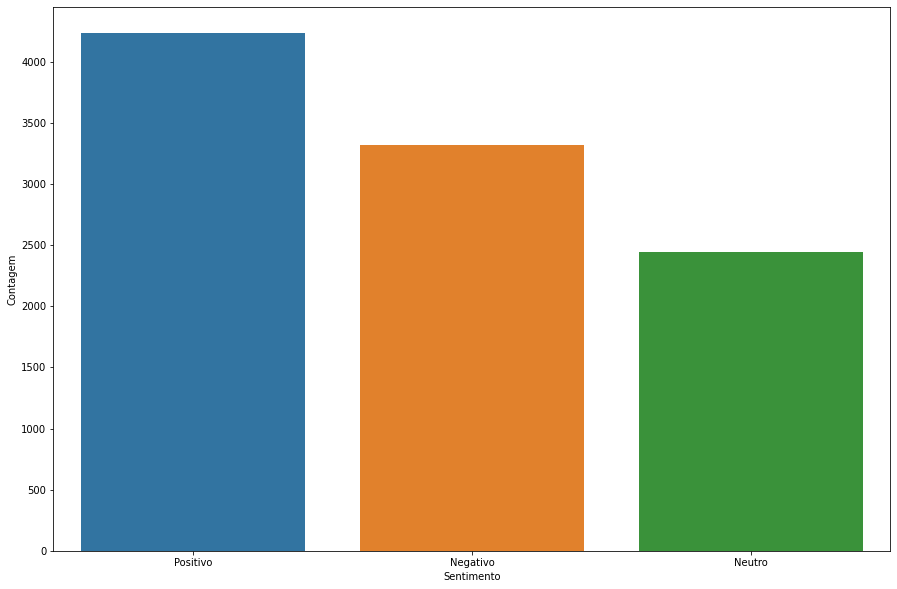

In [65]:
plt.figure(figsize=(15,10))
ax = sns.countplot(x="sentimento", data=df_teste)
plt.xlabel('Sentimento')
plt.ylabel('Contagem')
plt.show()